# Análise de Índices Espectrais para Estudo da Ilha de Calor em Castanhal - PA

Código utilizado para artigo do SBSR 2025

Etapas:
* Obtenção de Imagem Mediana de 2023 do Landsat-8 na área de interesse pelo Google Earth Engine
* Calculo da Temperatura de Superfície (LST), Índice Melhorado de Vegetação (EVI) e Índice de Urbanização (UI)
* Obtenção da Classificação de Uso e Cobertura do Solo por MapBiomas
* Transformação da Imagem para Dataframe e Amostragem de pontos em quatro classes de solo
* Geração dos Mapas de Índices Espectrais
* Análise da Relação Estatística da LST com os Índices EVI e UI

In [ ]:
!pip install rasterio mgwr pysal contextily pydot matplotlib_scalebar # Colab

In [2]:
import sys
import glob
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels as stm

import rasterio
from rasterio.plot import reshape_as_image, show
from rasterio.transform import xy
from rasterio.mask import mask
from rasterio.windows import from_bounds
from pyproj import CRS, transform
#import contextily as ctx
#import pydot

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Armazenamento em Nuvem
dir_img = '/content/drive/MyDrive/GEE_Images'
metadata_file_path = f'{dir_img}/mtl_2023.json'

In [6]:
# Armazenamento Local
import os
dir_img = os.getcwd()
metadata_file_path = os.path.join(dir_img, 'mtl_2023.json')

# Obtenção de Imagem Mediana de 2023 do Landsat-8 na área de interesse pelo Google Earth Engine

In [ ]:
import ee
import geemap.core as geemap

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='geers-phvguimaraesdev')

In [ ]:
# ROI - Município inteiro
dir  = '/content/drive/MyDrive/Artigos/RS_UHI_Amazon'
cast_shp = gpd.read_file(f'{dir}/Mun_Amazonia_Legal_2021/Mun_Amazonia_Legal_2021.shp')
cast_shp = cast_shp[cast_shp['NM_MUN'].isin(['Castanhal'])]
cast_shp.to_crs("EPSG:4326", inplace=True)
geometry = cast_shp.geometry.iloc[0]
geojson = geometry.__geo_interface__
roi = ee.Geometry(geojson)

In [ ]:
# ROI - Quadrado Urbano
cast = [[-48.0185, -1.3733], [-48.0185, -1.2243], [-47.8405, -1.2243], [-47.8405, -1.3733]]
# [[-48.07, -1.33], [-48.07, -1.25], [-47.87, -1.25], [-47.87, -1.33]]
cast_bbox = (-48.0185,-1.3733,-47.8405,-1.2243)
# (-48.07, -1.33, -47.87, -1.25)
roi = ee.Geometry.Polygon(cast)

In [ ]:
def maskL8sr(image):

    qa = image.select('QA_PIXEL') # Select the QA band

    # Define the cloud and cloud shadow bit masks (bits 3 and 4)
    cloudsBitMask = (1 << 3)  #  bit 3
    cloudShadowBitMask = (1 << 4) #  bit 4

    # Apply the bitwise AND operator and check if the bits are set to 0 (clear sky)
    cloud_shadow_clear = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
    clouds_clear = qa.bitwiseAnd(cloudsBitMask).eq(0)

    # Combine both masks (clear sky for both cloud and cloud shadow)
    mask = cloud_shadow_clear.And(clouds_clear)

    # Update the mask on the original image
    return image.updateMask(mask)

In [ ]:
import time

def export_to_drive(image, description, folder='GEE_Images', scale=30, region=None, max_pixels=1e9):

    if region is None:
        raise ValueError("Region must be provided as a list of coordinates.")

    roi = region.getInfo()['coordinates']

    task = ee.batch.Export.image.toDrive(**{
        'image': image,
        'description': description,
        'folder': folder,
        'scale': scale,
        'region': roi,
        'maxPixels': max_pixels
    })

    task.start()

    print(f'Starting export task: {description}')

    while task.active():
        print('Task is running...')
        time.sleep(10)

    status = task.status()

    if status['state'] == 'COMPLETED':
        print(f'Task {description} completed successfully.')
    else:
        print(f'Task {description} failed with status: {status["state"]}')
        print(f'Reason: {status.get("error_message", "Unknown error")}')

    return status['state']

In [ ]:
# Get 2023 DN image collection in ROI
col_2023 = ee.ImageCollection('LANDSAT/LC08/C02/T1') \
    .filterDate('2023-01-01', '2023-12-30') \
    .filterBounds(roi) \
    .map(maskL8sr)

In [ ]:
# Extract Digital Number Image Median
image_2023 = col_2023.median()

In [ ]:
# Retrieve metadata using getInfo()
mtl_2023 = col_2023.first().getInfo()
# Print metadata to see the structure
print(mtl_2023)

In [ ]:
# save metadata in JSON file
with open(metadata_file_path, 'w') as file:
    json.dump(mtl_2023, file, indent=4)

In [ ]:
# Export Image to drive
export_to_drive(image_2023, 'dn_img_2023', region=roi)

Starting export task: dn_img_2023
Task is running...
Task is running...
Task is running...
Task is running...
Task is running...
Task dn_img_2023 completed successfully.


'COMPLETED'

# Calculo da Temperatura de Superfície (LST), Índice Melhorado de Vegetação (EVI) e Índice de Urbanização (UI)

In [18]:
# Dados baixados
img_2023_path = f'{dir_img}/dn_img_2023.tif'

with open(metadata_file_path, 'r') as file:
    mtl_2023 = json.load(file)

In [19]:
def spectral_indices_calculation(src, metadata):

  toa_bands = {}

  ## Conversão de Números Digitais (DN) para Refletância de Topo de Atmosfera

  for i in range(1, 8):
        band_name = f'B{i}'
        band_data = src.read(i)
        mult = float(metadata['properties'][f'REFLECTANCE_MULT_BAND_{i}'])
        add = float(metadata['properties'][f'REFLECTANCE_ADD_BAND_{i}'])
        toa_bands[band_name] = band_data * mult + add

  ## Conversão de DN para Radiância Espectral TOA - Banda Termal

  band_name = 'B10'
  band_data = src.read(10)
  mult = float(metadata['properties']['RADIANCE_MULT_BAND_10'])
  add = float(metadata['properties']['RADIANCE_ADD_BAND_10'])
  L = band_data * mult + add

  ## Radiância para Temperatura de Brilho

  k1 = float(metadata['properties']['K1_CONSTANT_BAND_10'])
  k2 = float(metadata['properties']['K2_CONSTANT_BAND_10'])
  bt = k2 / np.log((k1/L)+1)

  ## NDVI para cálculo da Proporção de Vegetação e Emissividade do Solo

  nir = toa_bands['B5']
  red = toa_bands['B4']

  ndvi = (nir-red) / (nir+red)
  toa_bands['NDVI'] = ndvi
  pv = pow(((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())), 2)
  em = pv*0.004 + 0.986

  ## Temperatura de Brilho para Temperatura de Superfície (LST)

  w = 11.5e-6 # Comprimento médio da Onda Termal (11.5 micrômetros)
  p = 1.438e-2 # Constante
  toa_bands['LST'] = (bt / (1 + w * bt * np.log(em) / p)) - 273.15

  ## Outros Índices Espectrais

  blue = toa_bands['B2']
  green = toa_bands['B3']
  swir1 = toa_bands['B6']
  swir2 = toa_bands['B7']

  toa_bands['mNDWI'] = (green - nir) / (green + nir) # modified ND Water Index
  toa_bands['EVI'] = 2.5*(nir - red) / (nir + 6*red - 7.5*blue + 1) # enhanced vegetation index
  toa_bands['BI'] = ((swir1+red)-(nir+blue)) / ((swir1+red)+(nir+blue)) # bare soil index
  toa_bands['UI'] = (swir2 - nir) / (swir2 + nir) # urban index

  return toa_bands

In [20]:
src = rasterio.open(img_2023_path)
crs = src.crs
affine = src.transform
bounds = src.bounds
res = src.res

In [21]:
bands_2023 = spectral_indices_calculation(src, mtl_2023)

# Obtenção da Classificação de Uso e Cobertura do Solo por MapBiomas

In [22]:
# Classificação Uso e Cobertura da Terra MapBiomas - Castanhal/PA
# Obtido em: https://github.com/mapbiomas-brazil/user-toolkit
cast_lulc_path = f'{dir_img}/mapbiomas-brazil-collection-90-castanhal-2023.tif'

# Obter limite da Área de Interesse
roi_raster = rasterio.open(img_2023_path)
roi_bounds = roi_raster.bounds

# Cortar imagem
cast_lulc = rasterio.open(cast_lulc_path)
roi_window = cast_lulc.window(*roi_bounds)
cast_lulc_img = cast_lulc.read(1, window=roi_window)

# Adicionar às bandas
bands_2023['LULC'] = cast_lulc_img

# Geração dos Mapas de Índices Espectrais

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
from geopy.distance import geodesic
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Obtain the points of reference
center_latitude = (bounds.bottom + bounds.top) / 2
point1 = (center_latitude, bounds.left)
point2 = (center_latitude, bounds.left + 1)  # One degree of longitude to the right

# Calculate the distance in meters between these two points
distance_meters = geodesic(point1, point2).meters

# Custom format for longitude labels
def format_longitude(x, pos):
  if x < 0:
      return f"{abs(x):.2f}°W"
  return f"{x:.2f}°E"

# Custom format for latitude labels
def format_latitude(y, pos):
  if y < 0:
    return f"{abs(y):.2f}°S"
  return f"{y:.2f}°N"


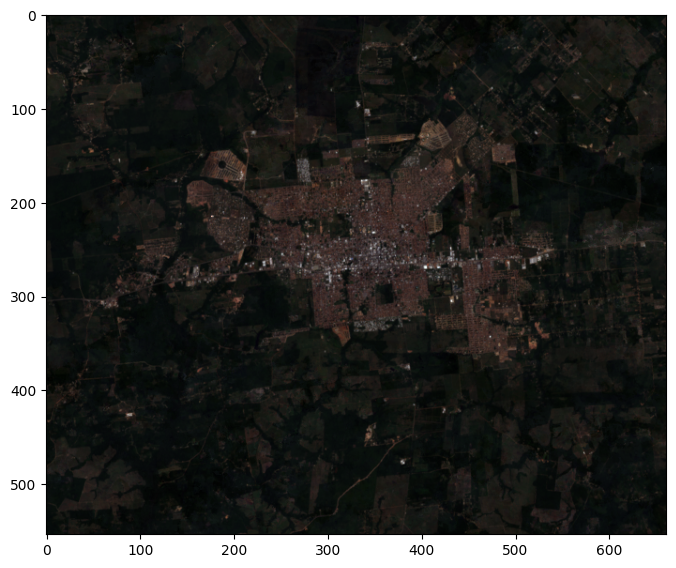

In [ ]:
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

blue = norm(bands_2023['B2'])
green = norm(bands_2023['B3'])
red = norm(bands_2023['B4'])

# Create RGB
rgb = np.dstack((red,green,blue))

plt.figure(figsize=(8, 8))
plt.imshow(rgb)

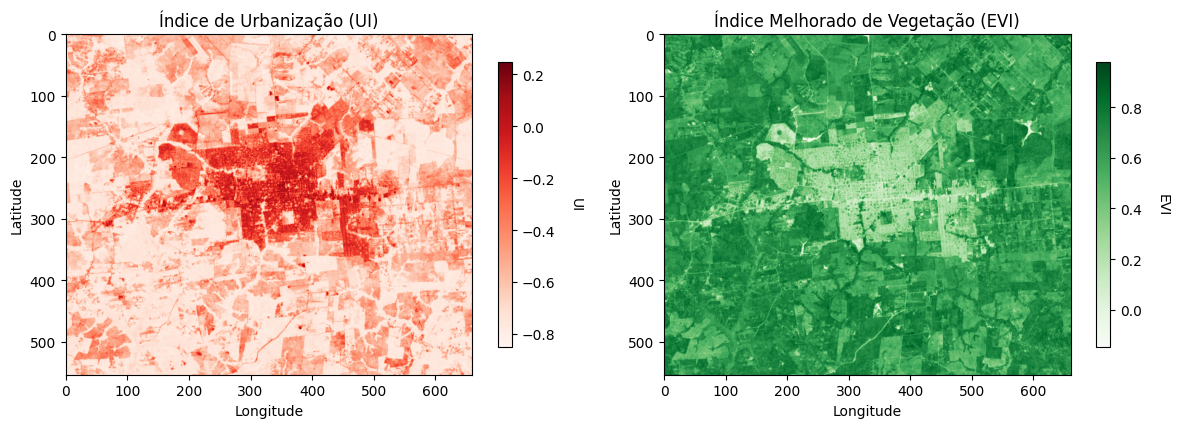

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Visualize UI
cax1 = ax1.imshow(bands_2023['UI'], cmap='Reds', origin='upper')
cbar1 = fig.colorbar(cax1, ax=ax1, orientation='vertical', shrink=0.5)
cbar1.set_label('UI', rotation=270, labelpad=20)
ax1.set_title('Índice de Urbanização (UI)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Apply the custom formatters to the axes
#ax1.xaxis.set_major_formatter(FuncFormatter(format_longitude))
#ax1.yaxis.set_major_formatter(FuncFormatter(format_latitude))

# Visualize EVI
cax2 = plt.imshow(bands_2023['EVI'], cmap='Greens')
cbar2 = fig.colorbar(cax2, ax=ax2, orientation='vertical', shrink=0.5)
cbar2.set_label('EVI', rotation=270, labelpad=20)
ax2.set_title('Índice Melhorado de Vegetação (EVI)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Apply the custom formatters to the axes
#ax2.xaxis.set_major_formatter(FuncFormatter(format_longitude))
#ax2.yaxis.set_major_formatter(FuncFormatter(format_latitude))

plt.tight_layout()
plt.savefig(f'{dir_img}/UI_EVI_Map_Median_2023_Cast-PA.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

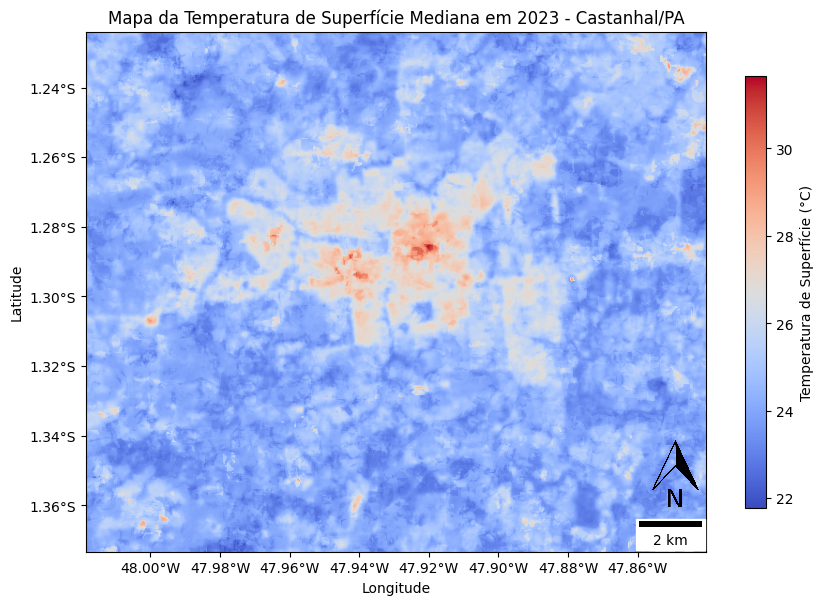

In [ ]:
plt.figure(figsize=(10, 8))
img = plt.imshow(bands_2023['LST'], cmap='coolwarm', extent=extent, origin='upper')
plt.colorbar(img, label='Temperatura de Superfície (°C)', shrink=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Apply the custom formatters to the axes
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

# Add a scale bar using the calculated distance for one degree of longitude
scalebar = ScaleBar(distance_meters, units="m", dimension="si-length", location='lower right')
plt.gca().add_artist(scalebar)

# Optional: add a textbox with image information
#textstr = f"Resolution: {res[0]} x {res[1]} meters\nBand: {n_bands} bands\nCRS: {crs}"
#props = dict(boxstyle='round', facecolor='white', alpha=0.8)
#plt.gca().text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)

# Seta Norte
img = plt.imread(f"{dir_img}/north_arrow.png")
imagebox = OffsetImage(img, zoom=0.020)
ab = AnnotationBbox(imagebox, (0.95, 0.15), frameon=False, xycoords='axes fraction')
plt.gca().add_artist(ab)

# Display the plot
plt.title("Mapa da Temperatura de Superfície Mediana em 2023 - Castanhal/PA")
plt.savefig(f'{dir_img}/LST_Map_Median_2023_Cast-PA.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

# Transformação da Imagem para Dataframe

In [23]:
def array_to_dataframe(dataset, affine, band=''):

    data = dataset[band]

    # Get coordinates (meshgrid of rows and columns)
    cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

    # Convert rows and columns to x, y coordinates using the affine transform
    xs, ys = rasterio.transform.xy(affine, rows, cols)

    # Flatten the arrays for creating the DataFrame
    df = pd.DataFrame({
        'x': np.array(xs).flatten(),
        'y': np.array(ys).flatten(),
        band: data.flatten()
    })

    # Remove NoData values (assuming NoData is represented by NaNs or specific values)
    df = df[~np.isnan(df[band])]

    return df

In [24]:
lst_df = array_to_dataframe(bands_2023, affine, 'LST')
ndvi_df = array_to_dataframe(bands_2023, affine, 'NDVI')
mnwdi_df = array_to_dataframe(bands_2023, affine, 'mNDWI')
evi_df = array_to_dataframe(bands_2023, affine, 'EVI')
bi_df = array_to_dataframe(bands_2023, affine, 'BI')
ui_df = array_to_dataframe(bands_2023, affine, 'UI')
#uhi_df = array_to_dataframe(bands_2023, affine, 'UHIn')
#uftvi_df = array_to_dataframe(bands_2023, affine, 'UTFVI')
#
lulc_df = array_to_dataframe(bands_2023, affine, 'LULC')

In [41]:
merged_df = pd.merge(ndvi_df, lst_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, mnwdi_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, evi_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, bi_df, on=['x', 'y'], how='inner')
merged_df = pd.merge(merged_df, ui_df, on=['x', 'y'], how='inner')
#merged_df = pd.merge(merged_df, uhi_df, on=['x', 'y'], how='inner')
#merged_df = pd.merge(merged_df, uftvi_df, on=['x', 'y'], how='inner')
#
merged_df = pd.merge(merged_df, lulc_df, on=['x', 'y'], how='inner')

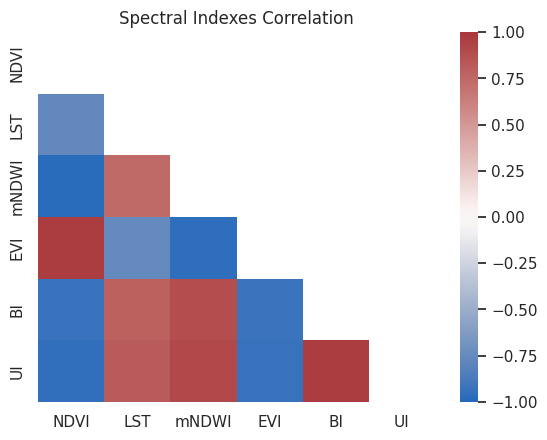

In [26]:
corr_df = merged_df.drop(['x', 'y','LULC'], axis=1).corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.set(style="white")
sns.heatmap(corr_df, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.title('Spectral Indexes Correlation')
#plt.savefig(f'{folder_path}/{band}_2019-2023_heatmap.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

In [ ]:
merged_df.set_index('LST', inplace=True)

In [ ]:
merged_df.to_csv(f'{dir_img}/df_2023.csv')

# Amostragem de pontos em quatro classes de solo

In [ ]:
merged_df = pd.read_csv(f'{dir_img}/df_2023.csv')

In [30]:
cast_lulc_data = pd.read_csv(f'{dir_img}/mapbiomas-brazil-collection-90-castanhal-area.csv')

lulc_data = pd.DataFrame({
    'LULC': cast_lulc_data['class'],
    'LULC_Name': cast_lulc_data['class_name']
})

lulc_data

,LULC,LULC_Name
0,3,Forest Formation
1,6,Áreas Naturales Inundables - Leñosas (Bosque I...
2,9,Forest Plantation
3,11,Wetland
4,12,"Grassland (Pastizal, Formación Herbácea)"
5,15,Pasture
6,24,Urban Infrastructure
7,25,Other Non Vegetated Area
8,30,Mining
9,33,"River, Lake and Ocean"


In [42]:
merged_df = pd.merge(merged_df, lulc_data, on='LULC', how='left')

In [43]:
merged_df.drop(['x', 'y','LULC'], axis=1, inplace=True)

In [44]:
print(merged_df['LULC_Name'].value_counts())

LULC_Name
Pasture                                                    175123
Forest Formation                                           103182
Urban Infrastructure                                        47305
Áreas Naturales Inundables - Leñosas (Bosque Inundable)      6392
Other Non Vegetated Area                                     4218
Mosaic of Crops                                              1259
River, Lake and Ocean                                         527
Mining                                                        218
Grassland (Pastizal, Formación Herbácea)                      166
Oil Palm                                                      153
Soy Beans                                                      68
Wetland                                                         3
Name: count, dtype: int64


In [45]:
classes = ['Pasture', 'Forest Formation', 'River, Lake and Ocean', 'Urban Infrastructure']
filter_df = merged_df[merged_df['LULC_Name'].isin(classes)]
# Define a dictionary mapping old class names to new ones
name_map = {
    'Pasture': 'pasture',
    'Forest Formation': 'forest',
    'River, Lake and Ocean': 'water_body',
    'Urban Infrastructure': 'urban',
}

# Replace class names based on the mapping
filter_df['LULC_Name'] = filter_df['LULC_Name'].replace(name_map)
print(filter_df['LULC_Name'].value_counts())

LULC_Name
pasture       175123
forest        103182
urban          47305
water_body       527
Name: count, dtype: int64


In [46]:
# Set the number of samples you want per bin
samples_per_bin = 200  # Example: 100 samples per bin
# Stratified sampling
df_sampled_lulc = filter_df.groupby('LULC_Name').apply(lambda x: x.sample(n=samples_per_bin, random_state=42))
# Reset the index after sampling
df_sampled_lulc = df_sampled_lulc.reset_index(drop=True)
# Check the result
print(df_sampled_lulc['LULC_Name'].value_counts())

LULC_Name
forest        200
pasture       200
urban         200
water_body    200
Name: count, dtype: int64


In [47]:
labels_lulc = df_sampled_lulc['LULC_Name']
features_lulc = df_sampled_lulc.drop(['LULC_Name'], axis=1)
features_lulc.columns

Index(['NDVI', 'LST', 'mNDWI', 'EVI', 'BI', 'UI'], dtype='object')

# Análise da Relação Estatística da LST com os Índices EVI e UI

Correlações no dataset amostrado por LULC

In [55]:
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error, r2_score


# mse = mean_squared_error(y_actual, y_predicted)
# rmse = mean_squared_error(y_actual, y_predicted, squared=False)
# mse = mean_squared_error(test_labels, predictions)
# r2 = r2_score(test_labels, predictions)

In [58]:
# Pearson Correlation
pearson_corr, pearson_p = pearsonr(df_sampled_lulc['UI'], df_sampled_lulc['LST'])
print(f'Pearson Correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3e})')

# Spearman Correlation
spearman_corr, spearman_p = spearmanr(df_sampled_lulc['UI'], df_sampled_lulc['LST'])
print(f'Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})')

# Linear Regression
x = df_sampled_lulc['UI'].values.reshape(-1, 1)
y = df_sampled_lulc['LST']
model = LinearRegression().fit(x, y)
slope = model.coef_[0]
intercept = model.intercept_
equation_text = f'Linear Fit: LST = {slope:.2f} * UI + {intercept:.2f}'
ui_lst_score = model.score(x, y)
print(f'R² Score: {ui_lst_score}')

lulc_colors = {
    'forest': 'green', 'pasture': 'gold', 'urban': 'red', 'water_body': 'blue'
}

Pearson Correlation: 0.856 (p-value: 2.405e-231)
Spearman Correlation: 0.813 (p-value: 7.905e-190)
R² Score: 0.7334846966201607


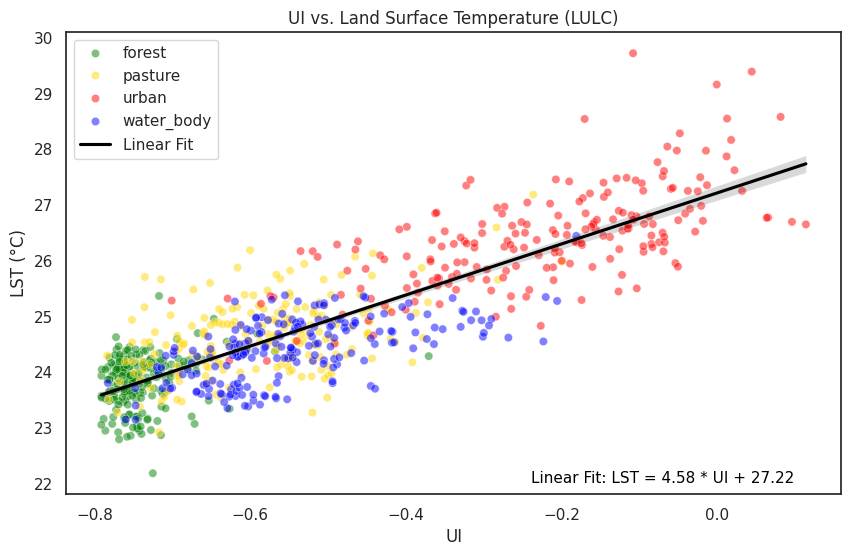

In [49]:
# Scatter Plot with Fitted Curves
plt.figure(figsize=(10, 6))
sns.scatterplot(x='UI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.5)
sns.regplot(x='UI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Linear Fit')
#sns.regplot(x='UI', y='LST', data=df_sampled_lulc, scatter=False, color='green', lowess=True, label='LOESS Fit')

plt.text(0.60, 0.05, equation_text, transform=plt.gca().transAxes,
         fontsize=11, color='black', verticalalignment='top')

plt.title('UI vs. Land Surface Temperature (LULC)')
plt.xlabel('UI')
plt.ylabel('LST (°C)')
plt.legend()
plt.savefig(f'{dir_img}/UI_vs_LST_LULC.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

In [59]:
# Pearson Correlation
pearson_corr, pearson_p = pearsonr(df_sampled_lulc['EVI'], df_sampled_lulc['LST'])
print(f'Pearson Correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3e})')

# Spearman Correlation
spearman_corr, spearman_p = spearmanr(df_sampled_lulc['EVI'], df_sampled_lulc['LST'])
print(f'Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})')

# Linear Regression
x = df_sampled_lulc['EVI'].values.reshape(-1, 1)
y = df_sampled_lulc['LST']
model = LinearRegression().fit(x, y)
slope = model.coef_[0]
intercept = model.intercept_
equation_text = f'Linear Fit: LST = {slope:.2f} * EVI + {intercept:.2f}'
evi_lst_score = model.score(x, y)
print(f'R² Score: {ui_lst_score}')

# Polynomial Regression
coeffs = Polynomial.fit(df_sampled_lulc['EVI'], df_sampled_lulc['LST'], deg=2).convert().coef
poly_eq = f'Polynomial Fit: LST = {coeffs[0]:.2f} + {coeffs[1]:.2f}*EVI {coeffs[2]:.2f}*EVI²'
x_vals = np.linspace(df_sampled_lulc['EVI'].min(), df_sampled_lulc['EVI'].max(), 100)
y_vals = coeffs[0] + coeffs[1] * x_vals + coeffs[2] * x_vals**2

lulc_colors = {
    'forest': 'green', 'pasture': 'gold', 'urban': 'red', 'water_body': 'blue'
}

Pearson Correlation: -0.321 (p-value: 1.222e-20)
Spearman Correlation: -0.408 (p-value: 1.997e-33)
R² Score: 0.10308596382437962


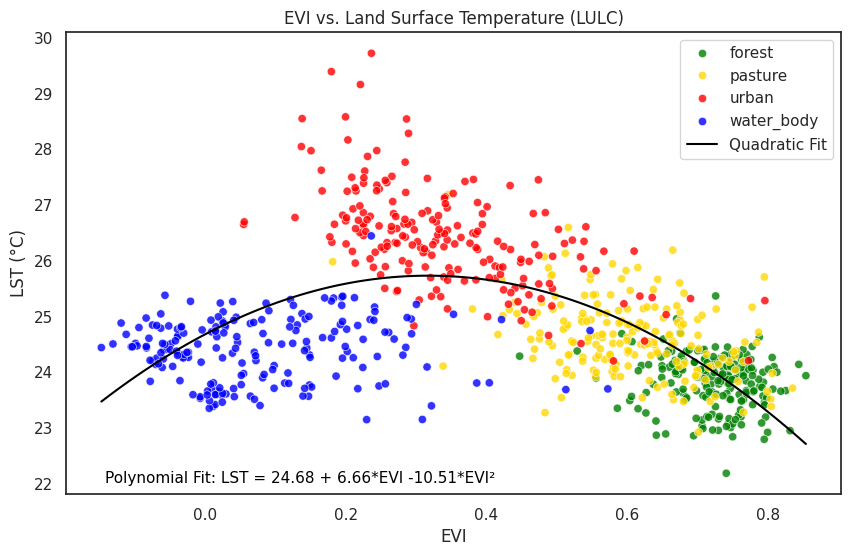

In [51]:
# Scatter Plot with Fitted Curves
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EVI', y='LST', hue='LULC_Name', palette=lulc_colors, data=df_sampled_lulc, alpha=0.8)
#sns.regplot(x='EVI', y='LST', data=df_sampled_lulc, scatter=False, color='black', label='Linear Fit')
#sns.regplot(x='EVI', y='LST', data=df_sampled_lulc, scatter=False, color='green', lowess=True, label='LOESS Fit')
plt.plot(x_vals, y_vals, color='black', label='Quadratic Fit')

#plt.text(0.60, 0.05, equation_text, transform=plt.gca().transAxes,
#         fontsize=11, color='black', verticalalignment='top')

plt.text(0.05, 0.05, poly_eq, transform=plt.gca().transAxes,
         fontsize=11, color='black', verticalalignment='top')

plt.title('EVI vs. Land Surface Temperature (LULC)')
plt.xlabel('EVI')
plt.ylabel('LST (°C)')
plt.legend()
plt.savefig(f'{dir_img}/EVI_vs_LST_LULC.jpeg', bbox_inches='tight', format='jpeg', dpi=300)
plt.show()

In [63]:
# Linear Regression
x = df_sampled_lulc[['EVI','UI']]#.values.reshape(-1, 1)
y = df_sampled_lulc['LST']
model = LinearRegression()
model.fit(x, y)
evi = model.coef_[0]
ui = model.coef_[1]
intercept = model.intercept_
predictions = model.predict(x)
print(f'Linear Fit: LST = EVI * {evi:.2f} + UI * {ui:.2f} + {intercept}')

Linear Fit: LST = EVI * 0.70 * UI + 5.03 + 27.147234939998302


In [67]:
# Using statsmodels
import statsmodels.api as sm

X = sm.add_constant(x)
rmodel = sm.OLS(y, X).fit()
predictions_statsmodels = rmodel.predict(X)
summary = rmodel.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                    LST   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1214.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.08e-242
Time:                        18:55:44   Log-Likelihood:                -699.41
No. Observations:                 800   AIC:                             1405.
Df Residuals:                     797   BIC:                             1419.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1472      0.054    500.694      0.0